In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as tfl
import tensorflow.keras.activations as activations
import matplotlib.pyplot as plt
from PIL import Image as im

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
print(x_train.shape)

(60000, 28, 28)


In [4]:
y_one_hot = tf.one_hot(y_train.astype('float32'), 10)
print(y_one_hot.shape)

(60000, 10)


In [5]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [6]:
def Categorical_encoder(latent_dimensionality):
    
    x = tfl.Input(shape = (28,28))
    x_flatten = tfl.Flatten()(x)
    
    x_fp = tfl.Dense(600, activation = 'relu')(x_flatten)
    x_fp = tfl.Dense(400, activation = 'relu')(x_fp)
    x_fp = tfl.Dense(150, activation = 'relu')(x_fp)
    logits = tfl.Dense(latent_dimensionality, activation = 'relu', name = 'logits')(x_fp)
    latent_category = tfl.Softmax()(logits[:,:10])
    
    encoder = tf.keras.Model(inputs = x, outputs = latent_category)
    
    return encoder

def Categorical_decoder(latent_dimensionality):
    
    latent_category = tfl.Input(shape = (10))
    support_latent = tfl.Input(shape = (latent_dimensionality - 10))
    
    complete_latent = tfl.Concatenate(axis=-1)([latent_category, support_latent])
    y = tfl.Dense(150, activation = 'relu')(complete_latent)
    y = tfl.Dense(400, activation = 'relu')(y)
    y = tfl.Dense(600, activation = 'relu')(y)
    y = tfl.Dense(784, activation = 'sigmoid')(y)
    y = tfl.Reshape((28,28))(y)
    
    decoder = tf.keras.Model(inputs = [latent_category, support_latent], outputs = y)
    
    return decoder

In [23]:
def combined_loss():

    def loss(y_true,y_pred):

        loss_binary_crossentropy =  tf.keras.losses.mean_squared_error(y_true[0], y_pred[0])
        latent_categorical_loss = 100 * tf.keras.losses.categorical_crossentropy(y_true[1], y_pred[1])     
        
        return loss_binary_crossentropy + latent_categorical_loss
   
    return loss

In [48]:
latent_dimensionality = 13   # 10 categorical latent dimensions, the rest of latent_dimensionality are support latents

In [62]:
my_encoder = Categorical_encoder(latent_dimensionality)
my_decoder = Categorical_decoder(latent_dimensionality)
latent_category = my_encoder(my_encoder.inputs)
support_latent = my_encoder.get_layer('logits').output[...,10:]
support_latent = tf.keras.layers.Activation('sigmoid')(support_latent)
reconstructions = my_decoder([latent_category, support_latent])
my_autoencoder = tf.keras.Model(inputs = my_encoder.inputs, outputs = [reconstructions, latent_category])

In [63]:
my_encoder.compile(loss = 'categorical_crossentropy',  optimizer = 'adam', metrics = ['accuracy'])

In [75]:
# pretraining encoder for discriminating
my_encoder.fit(x = x_train, y = y_one_hot, epochs = 5, batch_size = 100)

Epoch 1/5
600/600 [==============================] - 6s 10ms/step - loss: 0.0479 - accuracy: 0.9861
Epoch 2/5
600/600 [==============================] - 6s 10ms/step - loss: 0.0155 - accuracy: 0.9950
Epoch 3/5
600/600 [==============================] - 7s 11ms/step - loss: 0.0110 - accuracy: 0.9966
Epoch 4/5
600/600 [==============================] - 7s 12ms/step - loss: 0.0117 - accuracy: 0.9959
Epoch 5/5
600/600 [==============================] - 6s 11ms/step - loss: 0.0107 - accuracy: 0.9967


In [65]:
my_encoder.trainable = True

In [66]:
my_autoencoder.summary()

Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_40 (InputLayer)          [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_13 (Flatten)           (None, 784)          0           ['input_40[0][0]']               
                                                                                                  
 dense_91 (Dense)               (None, 600)          471000      ['flatten_13[0][0]']             
                                                                                                  
 dense_92 (Dense)               (None, 400)          240400      ['dense_91[0][0]']               
                                                                                           

In [67]:
my_autoencoder.compile(loss = combined_loss(), optimizer = 'adam', metrics = ['accuracy'])

In [76]:
my_autoencoder.fit(x = x_train, y = [x_train, y_one_hot], epochs = 10, batch_size = 100)

Epoch 1/10
600/600 [==============================] - 17s 28ms/step - loss: 965.9139 - model_40_loss: 961.6525 - model_39_loss: 4.2617 - model_40_accuracy: 0.1176 - model_39_accuracy: 0.9830
Epoch 2/10
600/600 [==============================] - 18s 30ms/step - loss: 1009.4271 - model_40_loss: 972.3973 - model_39_loss: 37.0290 - model_40_accuracy: 0.1187 - model_39_accuracy: 0.9233
Epoch 3/10
600/600 [==============================] - 16s 27ms/step - loss: 1001.9600 - model_40_loss: 962.4214 - model_39_loss: 39.5388 - model_40_accuracy: 0.1194 - model_39_accuracy: 0.9179
Epoch 4/10
600/600 [==============================] - 16s 27ms/step - loss: 971.6179 - model_40_loss: 940.8450 - model_39_loss: 30.7727 - model_40_accuracy: 0.1222 - model_39_accuracy: 0.9347
Epoch 5/10
600/600 [==============================] - 16s 27ms/step - loss: 967.7651 - model_40_loss: 934.6597 - model_39_loss: 33.1054 - model_40_accuracy: 0.1239 - model_39_accuracy: 0.9372
Epoch 6/10
600/600 [===================

In [81]:
sample = 10

Sample: 10
1/1 [==============================] - 0s 23ms/step


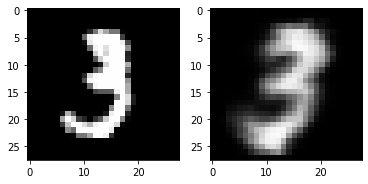

In [82]:
print('Sample: ' + str(sample))
task = x_train[sample,:,:].reshape(1,28,28)
tip = my_autoencoder.predict(task)
tip = tip[0]
task_img = im.fromarray(255 * task.reshape(28,28))
tip_img = im.fromarray(255 * tip.reshape(28,28))
plt.subplot(1, 2, 1)
plt.imshow(task_img)
plt.subplot(1, 2, 2)
plt.imshow(tip_img)
plt.show() 
sample += 1

1/1 [==============================] - 0s 168ms/step


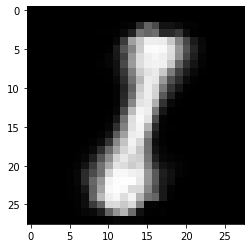

1/1 [==============================] - 0s 103ms/step


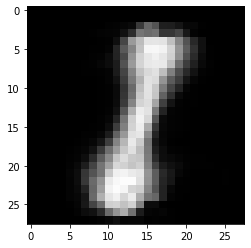

1/1 [==============================] - 0s 54ms/step


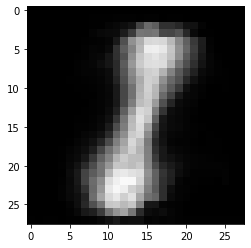

1/1 [==============================] - 0s 45ms/step


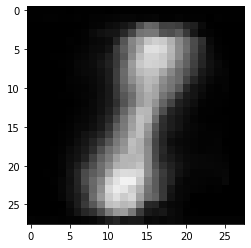

1/1 [==============================] - 0s 60ms/step


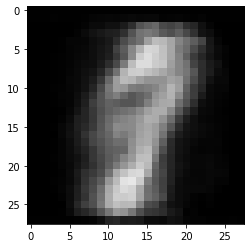

1/1 [==============================] - 0s 24ms/step


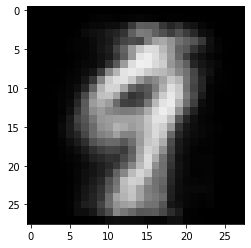

In [73]:
task1 = x_train[8,:,:].reshape(1,28,28)
task2 = x_train[22,:,:].reshape(1,28,28)
my_code1 = my_encoder.predict(task1)
my_code2 = my_encoder.predict(task2)

support_latent = tf.zeros([1,latent_dimensionality - 10])

steps = 6
step = (my_code1 - my_code2) / steps

latent_code = my_code1

for mutation in range(steps):
    my_tip = my_decoder.predict([latent_code, support_latent])
    my_tip_img = im.fromarray(255 * my_tip.reshape(28,28))
    plt.imshow(my_tip_img)
    plt.show()
    latent_code -= step

1/1 [==============================] - 0s 23ms/step


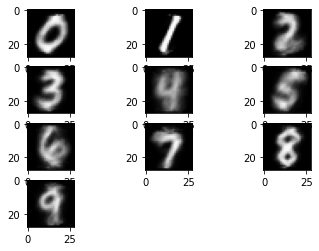

In [83]:
for i in range (10):
    latent_cat = tf.reshape(tf.one_hot(i, 10), (1,-1))
    null_support_latent = tf.zeros([1,latent_dimensionality - 10])
    latent_idea = my_decoder.predict([latent_cat, null_support_latent])
    latent_idea = latent_idea[0]
    latent_img = im.fromarray(255 * latent_idea.reshape(28,28))
    plt.subplot(4, 3, i + 1)
    plt.imshow(latent_img)
plt.show()